<a href="https://colab.research.google.com/github/zc619/M4R/blob/main/M4R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import minimize

import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Simulate AR(1) Time series with Gaussian errors

omega = 0.05 # attached to q
omega_hat = 0.1 # attached to xi

alpha = 0.6 # attached to u
beta = 0.02 # attached to q

gamma = 0.4 # attached to u
phi = 0.7 # attached to xi

n = 500 # Number of observations

# Parameters
phi1 = 0.8 # Autoregression coefficient
sigma = 1 # Standard deviation of errors
omega1 = 0

# Generate errors
np.random.seed(109) # set the random seed
normal_errors = np.random.normal(loc=0, scale=sigma, size=n) # generate errors
student_errors = np.random.standard_t(4, size=n)

# Generate AR(1) time series
y = np.zeros(n)
for i in range(1,n):
    y[i] = omega1 + phi1*y[i-1] + normal_errors[i]


In [ ]:
# Indicator function

def ind(y_i,q_i):
    if y_i <= q_i:
        return 1
    else:
        return 0

In [ ]:
# Tau function to create the probability levels

def tau(j):
    return [i/(j+1) for i in range(1,j+1)]
tau(3)

[0.25, 0.5, 0.75]

In [ ]:
def m(a,b):
  return min(a,b)*(1-max(a,b))

In [ ]:
# Quantiles function to create quantiles as defined by the DMQ model

def quantiles1(J, y):

    # generate initial values

    median = int((J-1)/2)
    y = y

    q = [np.zeros(n) for i in range(0,J)]
    xi = [np.zeros(n) for i in range(0,J)]
    u = [np.zeros(n) for i in range(0,J)]

    # calculate u initial values

    for i in range(0,J):
        if i < median:
            for j in range(0,i+1):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])

        elif i == median:
            for j in range(0,J):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])

        else:
            for j in range(i,J):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])

    # iterate the model, updating parameters where necessary

    for t in range(1,n):
        # update q median
        q[median][t] = omega + (beta * q[median][t-1]) + (alpha  * u[median][t-1]) # zeta defined as in paper, alpha needs reversed sign

        # update xis
        for i in range(0,J):
            if i == median:
                pass
            elif i < median:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) - (gamma * u[i][t-1])
            else:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) + (gamma * u[i][t-1])

        # update qs
        for i in range(median+1,J):
            q[i][t] = q[i-1][t] + np.exp(xi[i][t-1])

        for i in reversed(list(range(0,median))):
            q[i][t] = q[i+1][t] - np.exp(xi[i][t-1])


        # updates us
        for i in range(0,J):
            if i < median:
                for j in range(0,i+1):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])
            elif i == median:
                for j in range(0,J):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])
            else:
                for j in range(i,J):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])

    return q,u,xi

In [ ]:
# Quantiles function to create quantiles as defined by the DMQ model

def quantiles2(J, y):

    # generate initial values

    median = int((J-1)/2)
    y = y

    q = [np.zeros(n) for i in range(0,J)]
    xi = [np.zeros(n) for i in range(0,J)]
    u = [np.zeros(n) for i in range(0,J)]
    omegaj = np.zeros(J)
    a = np.zeros(J)

    # calculate omegaj values

    for i in range(0,J):
          if i < 1:
              for j in range(0,i+1):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(0,i+1):
                  for l_2 in range(0,i+1):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])

          elif i == 1:
              for j in range(0,J):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(0,J):
                  for l_2 in range(0,J):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])
          else:
              for j in range(i,J):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(i,J):
                  for l_2 in range(i,J):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])

    # calculate the a variables

    for i in range(0,J):
        a[i] = np.sqrt(omegaj[i])

    # calculate u initial values

    for i in range(0,J):
        if i < median:
            for j in range(0,i+1):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])
                u[i][0] = u[i][0]/a[i]
        elif i == median:
            for j in range(0,J):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])
                u[i][0] = u[i][0]/a[i]
        else:
            for j in range(i,J):
                u[i][0] += tau(J)[j] - ind(y[0],q[j][0])
                u[i][0] = u[i][0]/a[i]

    # iterate the model, updating parameters where necessary

    for t in range(1,n):
        # update q median
        q[median][t] = omega + (beta * q[median][t-1]) + (alpha  * u[median][t-1]) # zeta defined as in paper, alpha needs reversed sign

        # update xis
        for i in range(0,J):
            if i == median:
                pass
            elif i < median:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) - (gamma * u[i][t-1])
            else:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) + (gamma * u[i][t-1])

        # update qs
        for i in range(median+1,J):
            q[i][t] = q[i-1][t] + np.exp(xi[i][t-1])

        for i in reversed(list(range(0,median))):
            q[i][t] = q[i+1][t] - np.exp(xi[i][t-1])


        # updates us
        for i in range(0,J):
            if i < median:
                for j in range(0,i+1):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])
                    u[i][t] = u[i][t]/a[i]
            elif i == median:
                for j in range(0,J):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])
                    u[i][t] = u[i][t]/a[i]
            else:
                for j in range(i,J):
                    u[i][t] += tau(J)[j] - ind(y[t],q[j][t])
                    u[i][t] = u[i][t]/a[i]

    return q,u,xi

## Generating plot

In [ ]:
n = 500 # Number of observations

# Parameters
phi1 = 0.8 # Autoregression coefficient
sigma = 1 # Standard deviation of errors
omega1 = 0

# Generate errors
np.random.seed(109) # set the random seed
normal_errors = np.random.normal(loc=0, scale=sigma, size=n) # generate errors
student_errors = np.random.standard_t(4, size=n)

# Generate AR(1) time series
y_norm = np.zeros(n)
for i in range(1,n):
    y_norm[i] = omega1 + phi1*y_norm[i-1] + normal_errors[i]


y_student = np.zeros(n)
for i in range(1,n):
    y_student[i] = omega1 + phi1*y_student[i-1] + student_errors[i]

In [ ]:
# Function to plot the quantiles and the time series

def plot_quantiles_norm(n, scale):

    figure(figsize=(13.5, 8), dpi=80)
    plt.plot(y_norm, label = 'Time series')
    plt.title(f'J={n} quantiles for simulated AR(1) time series with normally distributed error')
    if scale == 1:
      for number in range(n):
        plt.plot(quantiles1(n, y_norm)[0][number], label=f'Quantile {tau(n)[number]:.3f} with a = 1')
    else:
      for number in range(n):
        plt.plot(quantiles2(n, y_norm)[0][number], label=f'Quantile {tau(n)[number]:.3f} with scaled a')

    plt.legend(loc='lower left')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig(f'J={n}_norm_a_{scale}')
    plt.show()

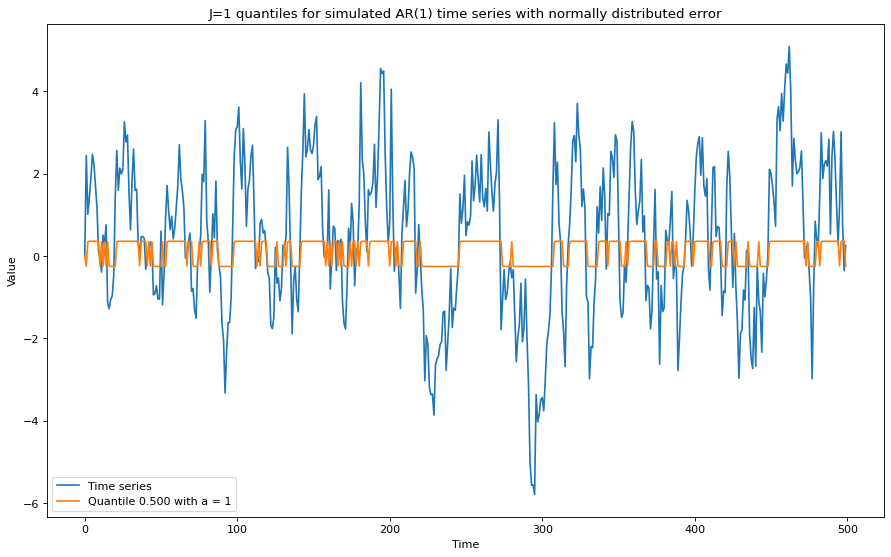

In [ ]:
plot_quantiles_norm(1,1)

In [ ]:
def plot_quantiles_student(n, scale):
    figure(figsize=(13.5, 8), dpi=80)
    plt.plot(y_student, label = 'Time series')
    plt.title(f"J={n} quantiles for simulated AR(1) time series with Student's t-distributed error")
    if scale == 1:
      for number in range(n):
        plt.plot(quantiles1(n, y_student)[0][number], label=f'Quantile {tau(n)[number]:.3f} with a = 1')
    else:
      for number in range(n):
        plt.plot(quantiles2(n, y_student)[0][number], label=f'Quantile {tau(n)[number]:.3f} with scaled a')

    plt.legend(loc='lower left')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig(f'J={n}_student_a_{scale}')
    plt.show()

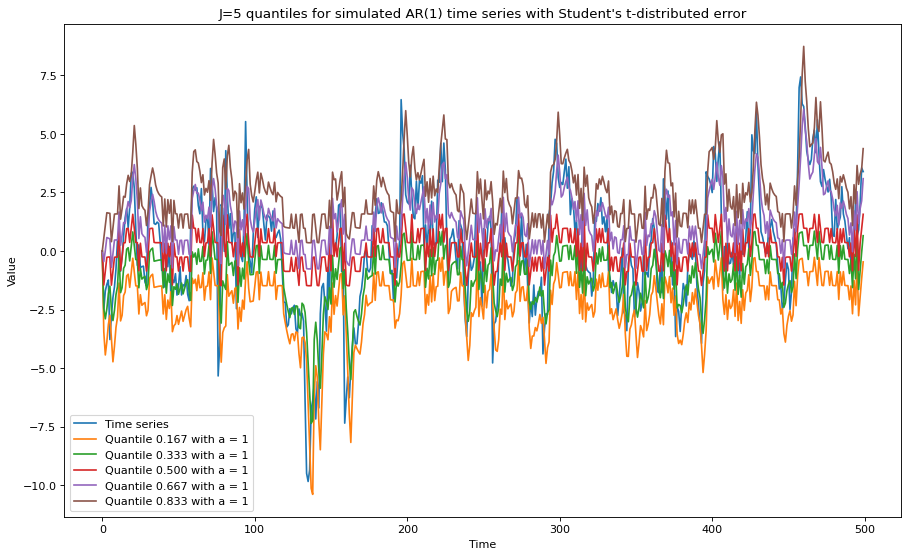

In [ ]:
plot_quantiles_student(5, 1)

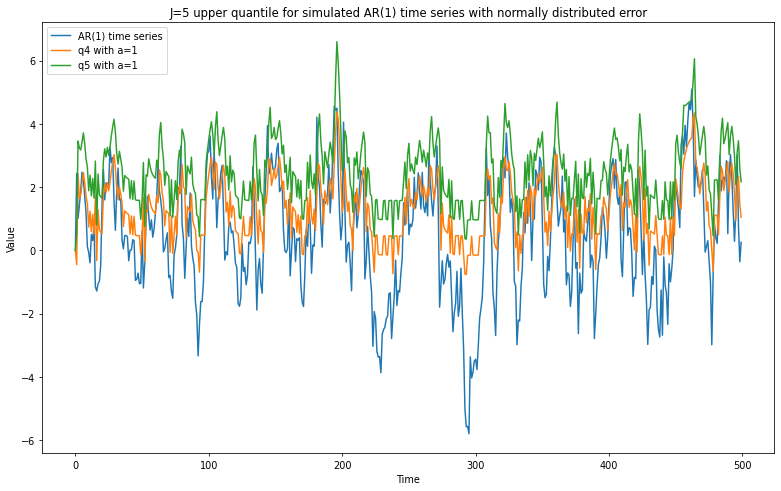

In [ ]:
figure(figsize=(13.5, 8), dpi=70)
plt.plot(y_norm, label = 'AR(1) time series')
plt.title("J=5 upper quantile for simulated AR(1) time series with normally distributed error")
plt.plot(quantiles1(5,y_norm)[0][3], label = 'q4 with a=1')
plt.plot(quantiles1(5,y_norm)[0][4], label = 'q5 with a=1')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.savefig('J=5_norm_upper_q')
plt.show()


In [ ]:
# function to plot the ustar values

def plot_ustar(n):
    q = quantiles1(n,y_student)
    ustar_sort = np.sort(q[1][int((n-1)/2)])
    y_sort = np.sort(y_student)
    figure(figsize=(12, 8), dpi=80)
    plt.plot(y_sort,ustar_sort)
    plt.xlabel("Ordered y_t values")
    plt.ylabel("Ordered u_t values")
#    plt.title(f"Ordered u_t values for J = {n} against quantiles of a Student's t-distribution with four degrees of freedom")
    plt.savefig(f"u_t J={n}")
    plt.show()

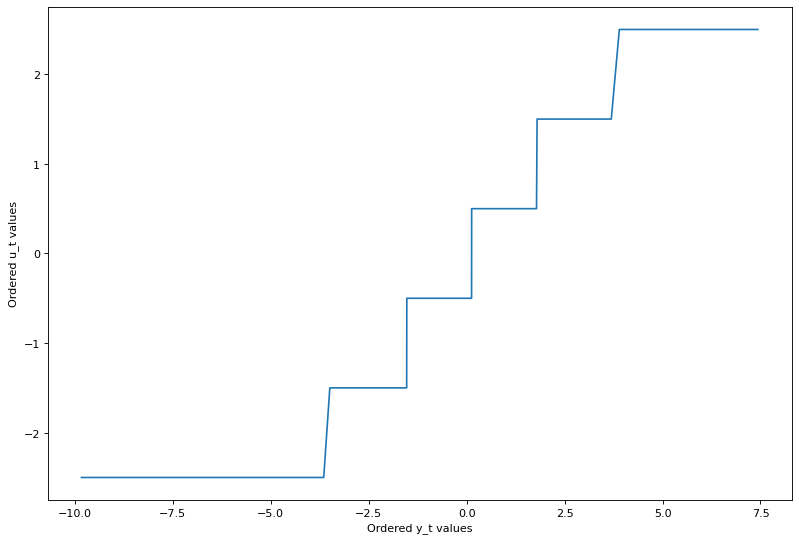

In [ ]:
plot_ustar(5)

# Smoothing

In [ ]:
# Smoothed quantiles as defined by the DMQ with smoothing

def smoothed_quantiles1(J, y, c):

    # generate initial values

    median = int((J-1)/2)
    y = y
    c = list(c)

    q = [np.zeros(n) for i in range(1,J+1)]
    xi = [np.zeros(n) for i in range(1,J)]
    u = [np.zeros(n) for i in range(1,J+1)]
    # c = [1/i for i in range(1,n+1)]
    # c = [0.5 for i in range(0,n)]

    # calculate u initial values

    for i in range(0,J):
        if i < median:
            for j in range(0,i+1):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))

        elif i == median:
            for j in range(0,J):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))

        else:
            for j in range(i,J):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))


    # iterate the model, updating parameters where necessary

    for t in range(1,n):
        # update q median
        q[median][t] = omega + (beta * q[median][t-1]) + (alpha * u[median][t-1])

        # update xis - update required
        for i in range(0,J-1):
            if i == median:
                pass
            elif i < median:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) - (gamma * u[i][t-1])
            else:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) + (gamma * u[i][t-1])


        # update qs
        for i in range(median+1,J):
            q[i][t] = q[i-1][t] + np.exp(xi[i-1][t-1])

        for i in reversed(list(range(0,median))):
            q[i][t] = q[i+1][t] - np.exp(xi[i][t-1])


        # updates us
        for i in range(0,J):
            if i < median:
                for j in range(0,i+1):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))

            elif i == median:
                for j in range(0,J):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))

            else:
                for j in range(i,J):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))


    return q,u,xi

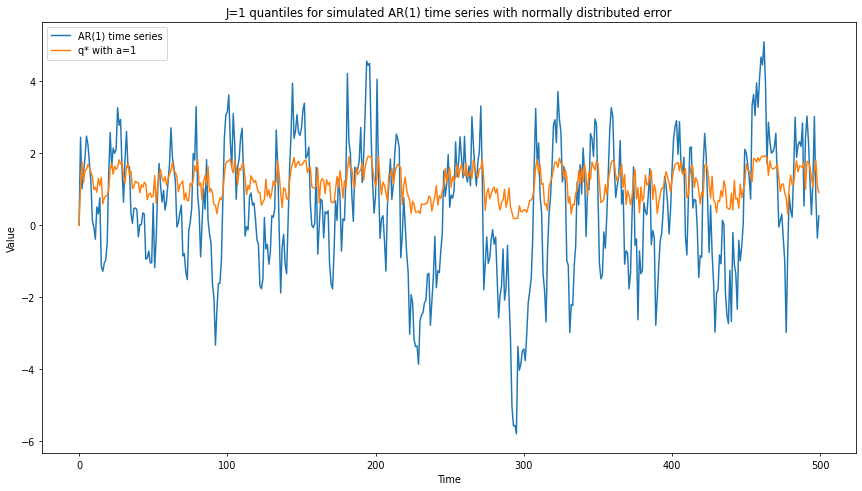

In [ ]:
figure(figsize=(15, 8), dpi=70)
plt.plot(y_norm, label = 'AR(1) time series')
plt.title("J=1 quantiles for simulated AR(1) time series with normally distributed error")
plt.plot(smoothed_quantiles1(3, y_norm, [1 for i in range(0,n)])[0][2], label = 'q* with a=1')
#plt.plot(quantiles2(1)[0][0], label = 'q* with scaled a')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.savefig('J=1_quantile_normal_a_scaled')
plt.show()

In [ ]:
# Smoothed quantiles as defined by the DMQ with smoothing

def smoothed_quantiles2(J, y ,c):

    # generate initial values

    median = int((J-1)/2)
    y = y
    c = list(c)

    q = [np.zeros(n) for i in range(1,J+1)]
    xi = [np.zeros(n) for i in range(1,J)]
    u = [np.zeros(n) for i in range(1,J+1)]
    # c = [1/i for i in range(1,n+1)]
    # c = [0.5 for i in range(0,n)]

    omegaj = np.zeros(J)
    a = np.zeros(J)

    # calculate omegaj values

    for i in range(0,J):
          if i < 1:
              for j in range(0,i+1):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(0,i+1):
                  for l_2 in range(0,i+1):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])

          elif i == 1:
              for j in range(0,J):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(0,J):
                  for l_2 in range(0,J):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])
          else:
              for j in range(i,J):
                  omegaj[i] += tau(J)[j]*(1-tau(J)[j])
              for l_1 in range(i,J):
                  for l_2 in range(i,J):
                      if l_2 == l_1:
                          pass
                      else:
                          omegaj[i] += m(tau(J)[l_1],tau(J)[l_2])

    # calculate the a variables

    for i in range(0,J):
        a[i] = np.sqrt(omegaj[i])

    # calculate u initial values

    for i in range(0,J):
        if i < median:
            for j in range(0,i+1):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))
                u[i][0] = u[i][0]/a[i]
        elif i == median:
            for j in range(0,J):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))
                u[i][0] = u[i][0]/a[i]
        else:
            for j in range(i,J):
                u[i][0] += tau(J)[j]-1/(1+np.exp((y[0]-q[j][0])/c[0]))
                u[i][0] = u[i][0]/a[i]

    # iterate the model, updating parameters where necessary

    for t in range(1,n):
        # update q median
        q[median][t] = omega + (beta * q[median][t-1]) + (alpha * u[median][t-1])

        # update xis - update required
        for i in range(0,J-1):
            if i == median:
                pass
            elif i < median:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) - (gamma * u[i][t-1])
            else:
                xi[i][t] = omega_hat + (phi * xi[i][t-1]) + (gamma * u[i][t-1])


        # update qs
        for i in range(median+1,J):
            q[i][t] = q[i-1][t] + np.exp(xi[i-1][t-1])

        for i in reversed(list(range(0,median))):
            q[i][t] = q[i+1][t] - np.exp(xi[i][t-1])


        # updates us
        for i in range(0,J):
            if i < median:
                for j in range(0,i+1):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))
                    u[i][t] = u[i][t]/a[i]
            elif i == median:
                for j in range(0,J):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))
                    u[i][t] = u[i][t]/a[i]
            else:
                for j in range(i,J):
                    u[i][t] += tau(J)[j]-1/(1+np.exp((y[t]-q[j][t])/c[t]))
                    u[i][t] = u[i][t]/a[i]


    return q,u,xi

## Generating Smoothed Plots

In [ ]:
n = 500 # Number of observations

# Parameters
phi1 = 0.8 # Autoregression coefficient
sigma = 1 # Standard deviation of errors
omega1 = 0

# Generate errors
np.random.seed(109) # set the random seed
normal_errors = np.random.normal(loc=0, scale=sigma, size=n) # generate errors
student_errors = np.random.standard_t(4, size=n)

# Generate AR(1) time series
y_norm = np.zeros(n)
for i in range(1,n):
    y_norm[i] = omega1 + phi1*y_norm[i-1] + normal_errors[i]


y_student = np.zeros(n)
for i in range(1,n):
    y_student[i] = omega1 + phi1*y_student[i-1] + student_errors[i]

In [ ]:
# Function to plot the quantiles and the time series

def plot_smoothed_quantiles_norm(n, scale, c):
    c = list(c)
    figure(figsize=(13.5, 8), dpi=80)
    plt.plot(y_norm, label = 'Time series')
    plt.title(f'J={n} smoothed quantiles for simulated AR(1) time series with normally distributed error')
    if scale == 1:
      for number in range(n):
        plt.plot(smoothed_quantiles1(n, y_norm, c)[0][number], label=f'Quantile {tau(n)[number]:.3f} with a = 1')
    else:
      for number in range(n):
        plt.plot(smoothed_quantiles2(n, y_norm, c)[0][number], label=f'Quantile {tau(n)[number]:.3f} with scaled a')

    plt.legend(loc='lower left')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig(f'J={n}_smooth_norm_a_{scale}_2')
    plt.show()

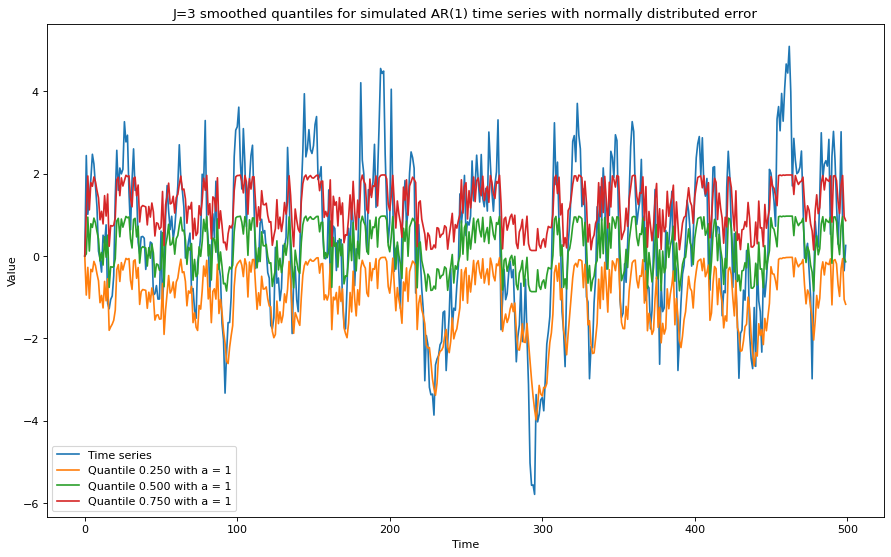

In [ ]:
plot_smoothed_quantiles_norm(3, 1, [0.3 for i in range(0,n)])

In [ ]:
def plot_smoothed_quantiles_student(n, scale, c):
    c = list(c)
    figure(figsize=(13.5, 8), dpi=80)
    plt.plot(y_student, label = 'Time series')
    plt.title(f"J={n} smoothed quantiles for simulated AR(1) time series with Student's t-distributed error")
    if scale == 1:
      for number in range(n):
        plt.plot(smoothed_quantiles1(n, y_student, c)[0][number], label=f'Quantile {tau(n)[number]:.3f} with a = 1')
    else:
      for number in range(n):
        plt.plot(smoothed_quantiles2(n, y_student, c)[0][number], label=f'Quantile {tau(n)[number]:.3f} with scaled a')

    plt.legend(loc='lower left')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig(f'J={n}_smooth_student_a_{scale}_ct_')
    plt.show()

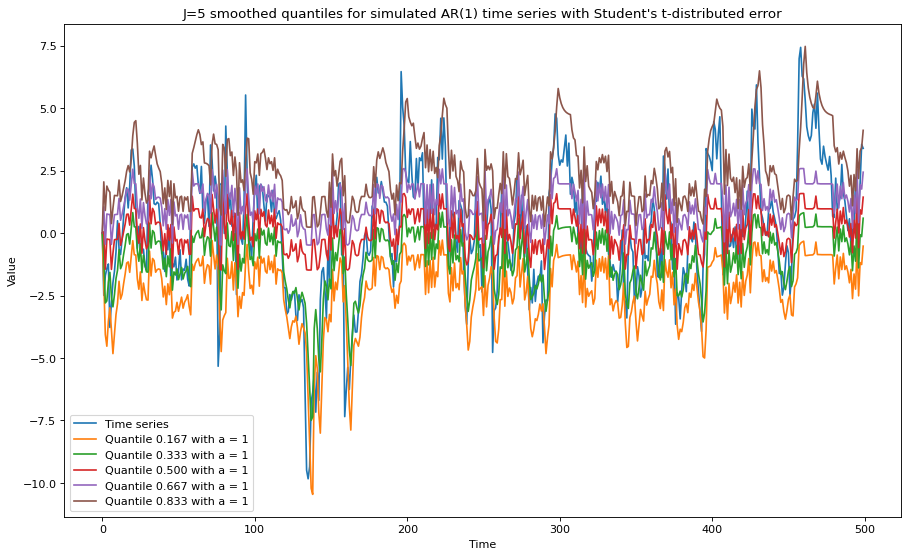

In [ ]:
plot_smoothed_quantiles_student(5, 1, [0.1 for i in range(0,n)])

In [ ]:
# function to plot the ustar values
def plot_smoothed_ustar(n, c):
    c = list(c)
    q = smoothed_quantiles1(n,y_student,c)
    ustar_sort = np.sort(q[1][int((n-1)/2)])
    y_sort = np.sort(y_student)
    figure(figsize=(12, 8), dpi=80)
    plt.plot(y_sort,ustar_sort)
    plt.xlabel("Ordered y_t values")
    plt.ylabel("Ordered smoothed u_t values")
#    plt.title(f"Ordered smoothed u_t values for J = {n} against quantiles of a Student's t-distribution with four degrees of freedom")
    plt.savefig(f"u_t_smooth_J={n}_c_sin")
    plt.show()

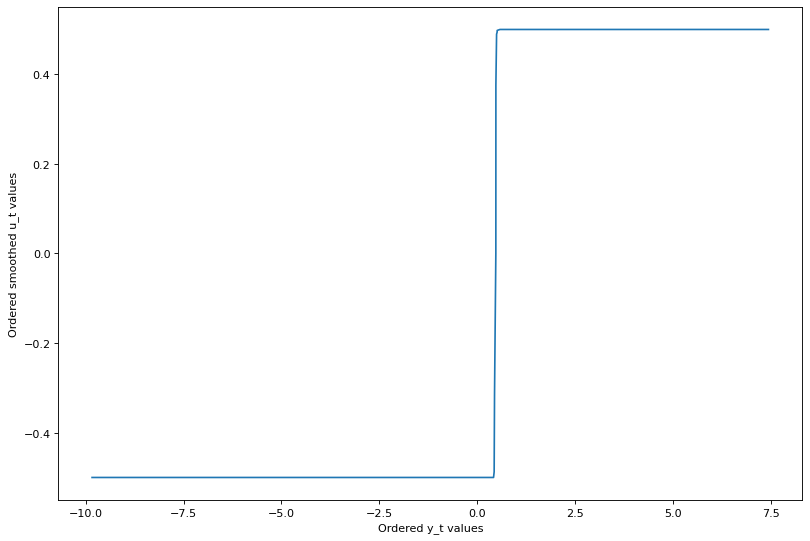

In [ ]:
plot_smoothed_ustar(1,[-1/i for i in range(1,n+1)])

In [ ]:
# function to plot the ustar values
def plot_all_ustar(n, c1):
    c1 = list(c1)
#    c2 = list(c2)
#    c3 = list(c3)

    q_smooth1 = smoothed_quantiles1(n,y_student,c1)
#    q_smooth2 = smoothed_quantiles1(n,y_student,c2)
#    q_smooth3 = smoothed_quantiles1(n,y_student,c3)

    q = quantiles1(n,y_student)

    smooth_ustar_sort1 = np.sort(q_smooth1[1][int((n-1)/2)])
#   smooth_ustar_sort2 = np.sort(q_smooth2[1][int((n-1)/2)])
#   smooth_ustar_sort3 = np.sort(q_smooth3[1][int((n-1)/2)])
    ustar_sort = np.sort(q[1][int((n-1)/2)])

    y_sort = np.sort(y_student)

    figure(figsize=(12, 8), dpi=80)

    plt.plot(y_sort,ustar_sort, label = "u_t")
    plt.plot(y_sort,smooth_ustar_sort1, label = "smoothed u_t with c_t = -1/i")
#    plt.plot(y_sort,smooth_ustar_sort2, label = "smoothed u_t with c_t = sin(t)")
#    plt.plot(y_sort,smooth_ustar_sort3, label = "smoothed u_t with c_t = -1/i")


    plt.xlabel("Ordered y_t values")
    plt.ylabel("Ordered u_t values")
#    plt.title(f"Ordered smoothed u_t values for J = {n} against quantiles of a Student's t-distribution with four degrees of freedom")
    plt.legend()
    plt.savefig(f"u_t_all_J={n}_c_neg")
    plt.show()


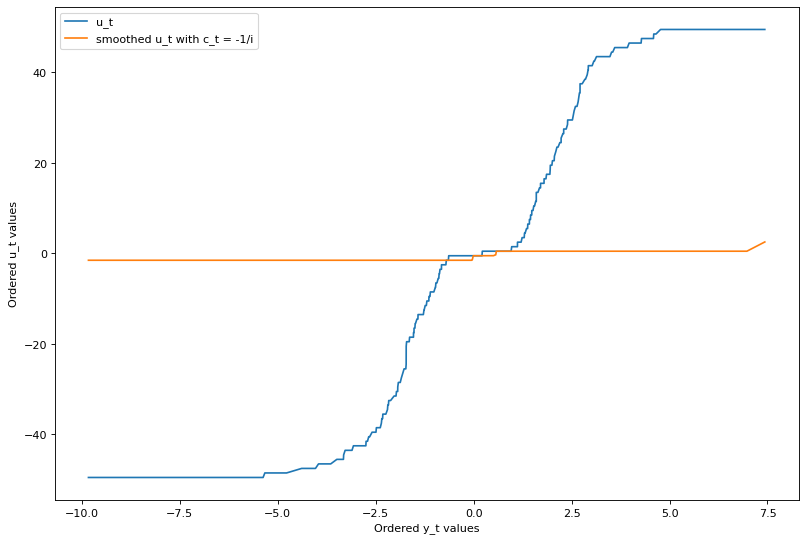

In [ ]:
plot_all_ustar(99, [-1/i for i in range(1,501)])
#  [np.sin(i) for i in range(1,501)]

# Comparison

In [ ]:
n = 500 # Number of observations

# Parameters
phi1 = 0.8 # Autoregression coefficient
sigma = 1 # Standard deviation of errors
omega1 = 0

# Generate errors
np.random.seed(109) # set the random seed
normal_errors = np.random.normal(loc=0, scale=sigma, size=n) # generate errors
student_errors = np.random.standard_t(4, size=n)

# Generate AR(1) time series
y_norm = np.zeros(n)
for i in range(1,n):
    y_norm[i] = omega1 + phi1*y_norm[i-1] + normal_errors[i]


y_student = np.zeros(n)
for i in range(1,n):
    y_student[i] = omega1 + phi1*y_student[i-1] + student_errors[i]

In [ ]:
diff = 0
c = [0.05 for i in range(0,n)]
for t in range(0,n):
  for i in range(0,5):
    diff += abs(quantiles1(5, y_norm)[0][i][t] - smoothed_quantiles1(5,y_norm,c)[0][i][t])

print(diff)

503.8153454522686


In [ ]:
MSE = 0
c = [0.5 for i in range(0,n)]
for t in range(0,n):
  for i in range(0,5):
    MSE += (quantiles1(5, y_norm)[0][i][t] - smoothed_quantiles1(5,y_norm,c)[0][i][t])**2
  MSE = MSE/2500

print(MSE)

5.6416312153096235e-05


# Optimisation

In [ ]:
# Define the objective function
def objective(x):

    q = quantiles1(1, y_student)[0]
    u = quantiles1(1, y_student)[1]
    xi = quantiles1(1, y_student)[2]
    y = y_student

    median = 0

    omega = x[0]
    alpha = x[1]
    beta = x[2]

    val = 0

    for i in range(1,n):
      val += (y[i] - (omega + alpha * u[median][i-1] + beta * q[median][i-1])) * (0.5 - ind(y[i],(omega + alpha * u[median][i-1] + beta * q[median][i-1])))
      return val

# Initial guess
x0 = np.array([0.5, 0.02, 0.6])

# Call the minimize function
result = minimize(objective, x0, method = 'Nelder-Mead')

# Print the optimization result
print(result)
print("Optimized values:", result.x)
print("Optimized objective function value:", result.fun)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.2578430902410176e-05
             x: [-2.453e+00  8.637e-02  1.678e+00]
           nit: 55
          nfev: 110
 final_simplex: (array([[-2.453e+00,  8.637e-02,  1.678e+00],
                       [-2.453e+00,  8.636e-02,  1.678e+00],
                       [-2.453e+00,  8.637e-02,  1.678e+00],
                       [-2.453e+00,  8.636e-02,  1.678e+00]]), array([ 1.258e-05,  1.786e-05,  2.672e-05,  2.934e-05]))
Optimized values: [-2.45317879  0.08636585  1.67806157]
Optimized objective function value: 1.2578430902410176e-05


In [ ]:
# Define the objective function
def objective3(theta):

    J = 3
    n = 500
    y = y_student

    q = quantiles1(1, y_student)[0]
    u = quantiles1(1, y_student)[1]
    xi = quantiles1(1, y_student)[2]

    median = 1

    omega = theta[0]
    alpha = theta[1]
    beta = theta[2]
    omega_hat = theta[3]
    gamma = theta[4]
    phi = theta[5]

    val = 0

    for i in range(1,n):
      for j in range(0,J):
        if j < median:
          val += (y[i] - (omega + alpha * u[j][i-1] + beta * q[j][i-1]) - np.exp(omega_hat + gamma * u[j][i-1] + phi * xi[j][i-1])) * (0.5 - ind(y[i],(omega + alpha * u[j][i-1] + beta * q[j][i-1])) - np.exp(omega_hat + gamma * u[j][i-1] + phi * xi[j][i-1]))
        elif j == median:
          val += (y[i] - (omega + alpha * u[j][i-1] + beta * q[j][i-1])) * (0.5 - ind(y[i],(omega + alpha * u[j][i-1] + beta * q[j][i-1])))
        else:
          val += (y[i] - (omega + alpha * u[j][i-1] + beta * q[j][i-1]) + np.exp(omega_hat + gamma * u[j][i-1] + phi * xi[j][i-1])) * (0.5 - ind(y[i],(omega + alpha * u[j][i-1] + beta * q[j][i-1])) + np.exp(omega_hat + gamma * u[j][i-1] + phi * xi[j][i-1]))
          return val

# Initial guess
theta0 = np.array([0.4, 0.6, 0.02, 0.1, 0.4, 0.7])

# Call the minimize function
result = minimize(objective3, theta0, method = 'Nelder-Mead')

# Print the optimization result
print(result)
print("Optimized values:", result.x)
print("Optimized objective function value:", result.fun)

IndexError: ignored

# Figures


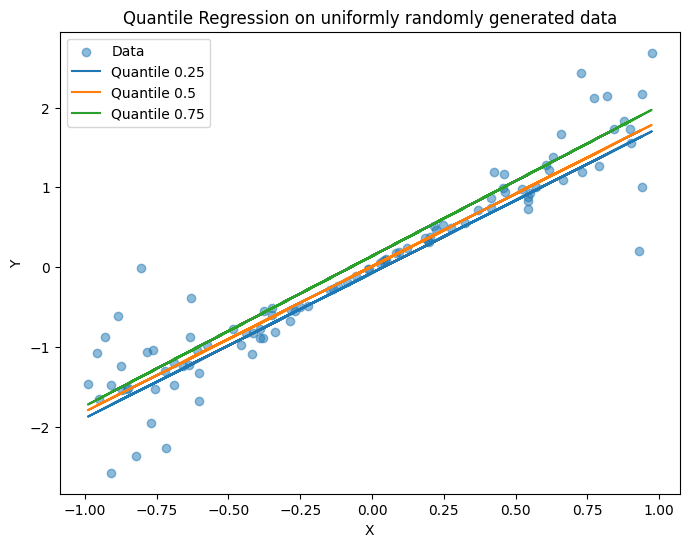

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set the random seed for reproducibility
np.random.seed(42)

# Generate the randomly distributed data
n = 100  # Number of data points
x = np.random.uniform(low=-1, high=1, size=n)
y = 2 * x +  x**2 * np.random.normal(loc=0, scale=1, size=n)

# Fit the quantile regression model
quantiles = [0.25, 0.5, 0.75]  # Quantile levels
X = sm.add_constant(x)  # Add constant term to the design matrix
model = sm.QuantReg(y, X)

results = []
for q in quantiles:
    result = model.fit(q=q)
    results.append(result)

# Plotting the quantile regression lines
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, alpha=0.5, label='Data')

for i, result in enumerate(results):
    y_pred = result.predict(X)
    ax.plot(x, y_pred, label=f'Quantile {quantiles[i]}')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile Regression on uniformly randomly generated data')
ax.legend()

# Show the plot
plt.savefig('Quantile')
plt.show()


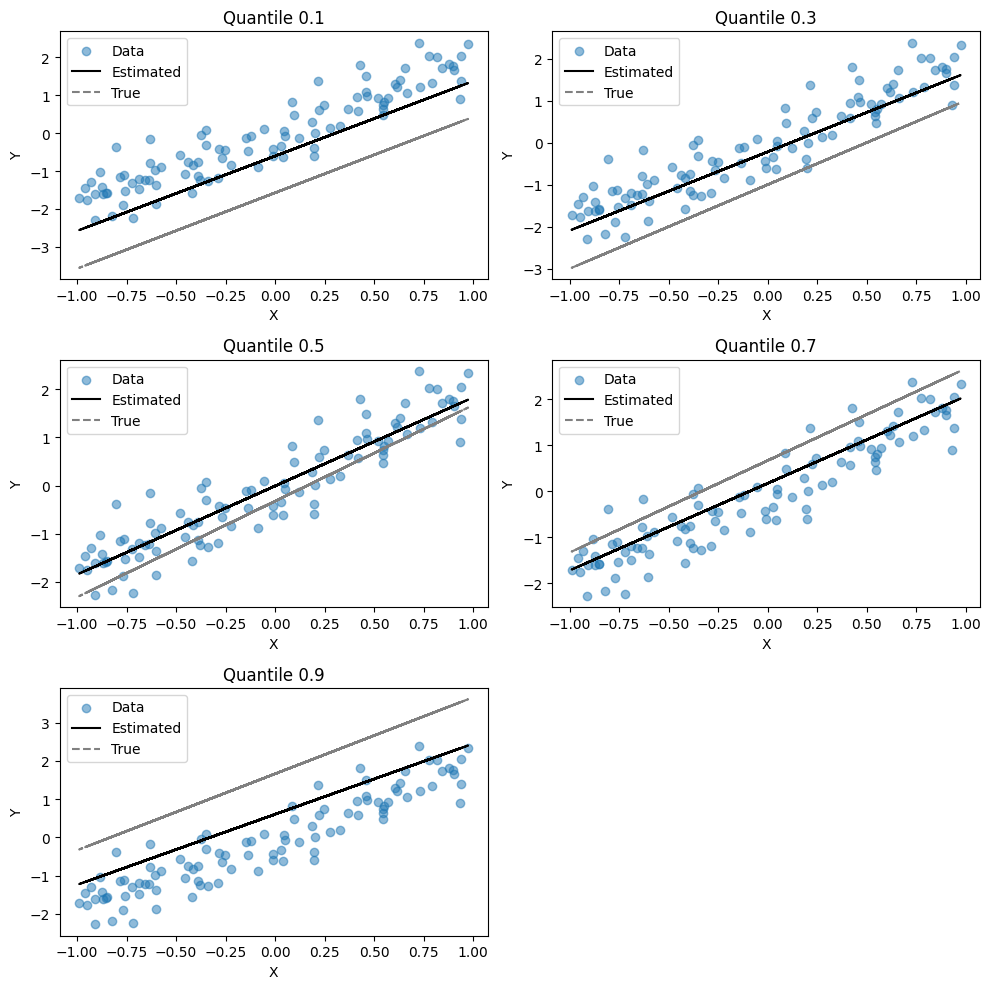

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set the random seed for reproducibility
np.random.seed(42)

# Generate the randomly distributed data
n = 100  # Number of data points
x = np.random.uniform(low=-1, high=1, size=n)
y = 2 * x + np.random.normal(loc=0, scale=0.5, size=n)

# True quantiles
quantiles_true = [0.1, 0.3, 0.5, 0.7, 0.9]

# Fit the quantile regression model
X = sm.add_constant(x)  # Add constant term to the design matrix
model = sm.QuantReg(y, X)

# Calculate the number of rows and columns in the grid
nrows = int(np.ceil(len(quantiles_true) / 2))
ncols = 2

# Set up the subplots grid
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

# Plotting the quantile regression lines
for i, quantile in enumerate(quantiles_true):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]

    result = model.fit(q=quantile)
    y_pred = result.predict(X)

    # Plot estimated quantiles in black
    ax.scatter(x, y, alpha=0.5, label='Data')
    ax.plot(x, y_pred, color='black', label='Estimated')

    # Calculate and plot true conditional quantiles in gray
    quantile_true = np.percentile(y, quantile * 100)
    ax.plot(x, x * 2 + quantile_true, color='gray', linestyle='--', label='True')

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Quantile {quantile}')
    ax.legend()

# Remove any empty subplots
if len(quantiles_true) < nrows * ncols:
    for i in range(len(quantiles_true), nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(axes[row, col])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


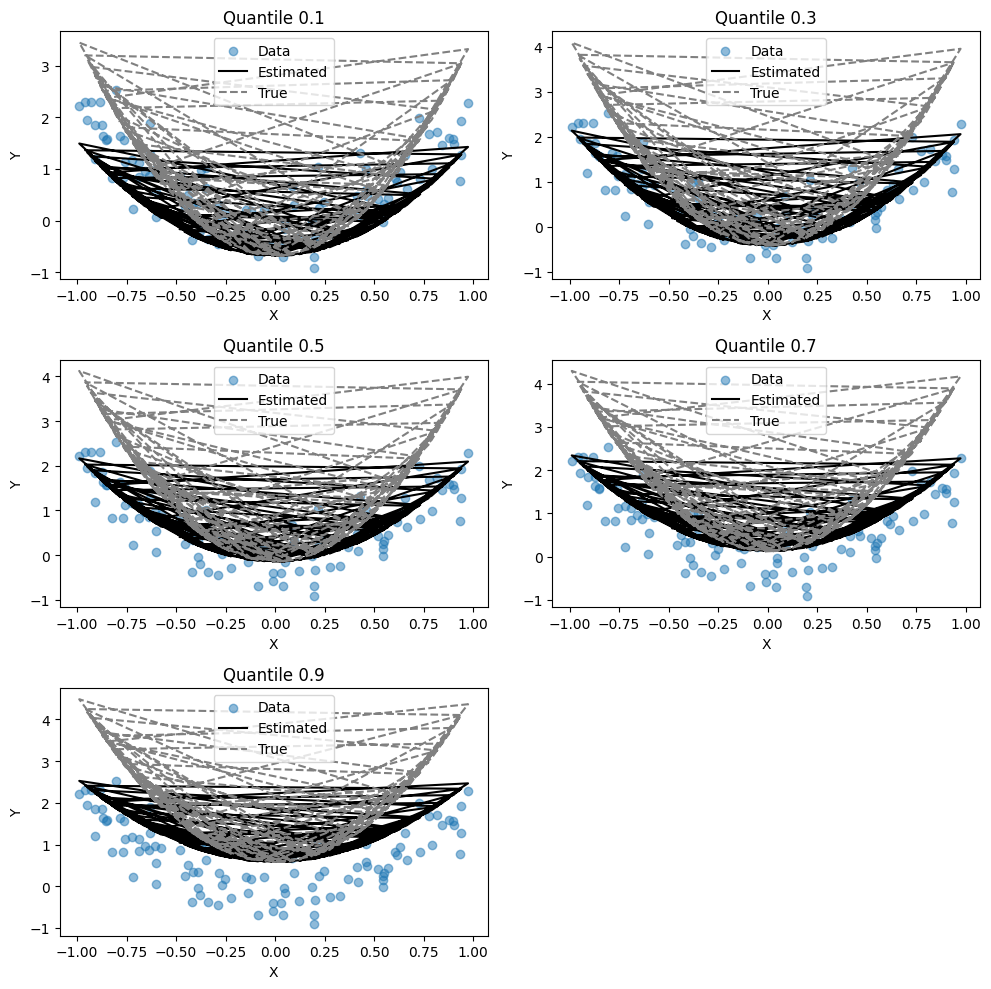

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set the random seed for reproducibility
np.random.seed(42)

# Generate the randomly distributed data
n = 100  # Number of data points
x = np.random.uniform(low=-1, high=1, size=n)
y = 2 * x**2 + np.random.normal(loc=0, scale=0.5, size=n)

# True quantiles
quantiles_true = [0.1, 0.3, 0.5, 0.7, 0.9]

# Fit the quantile regression model
X = sm.add_constant(x**2)  # Add constant term to the design matrix
model = sm.QuantReg(y, X)

# Calculate the number of rows and columns in the grid
nrows = int(np.ceil(len(quantiles_true) / 2))
ncols = 2

# Set up the subplots grid
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

# Plotting the quantile regression lines
for i, quantile in enumerate(quantiles_true):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]

    result = model.fit(q=quantile)
    y_pred = result.predict(X)

    # Plot estimated quantiles in black
    ax.scatter(x, y, alpha=0.5, label='Data')
    ax.plot(x, y_pred, color='black', label='Estimated')

    # Calculate and plot true conditional quantiles in gray
    quantile_true = np.percentile(y, quantile * 100)
    ax.plot(x, 2 * x**2 + result.params[1] * x**2 + result.params[0], color='gray', linestyle='--', label='True')

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Quantile {quantile}')
    ax.legend()

# Remove any empty subplots
if len(quantiles_true) < nrows * ncols:
    for i in range(len(quantiles_true), nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(axes[row, col])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


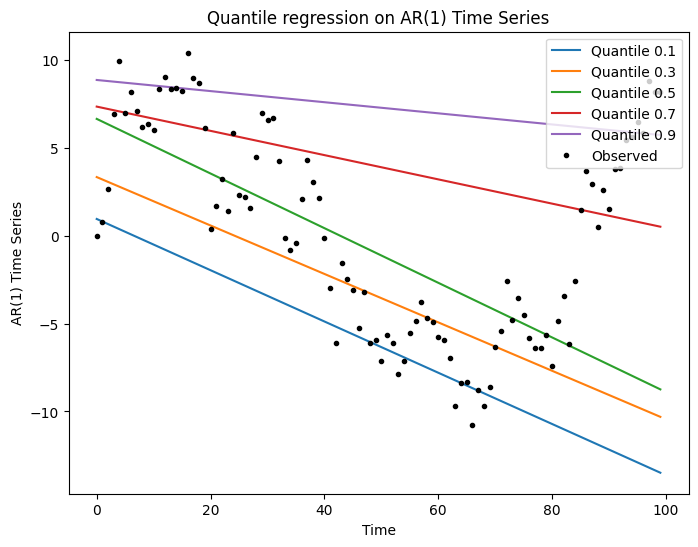

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(0)

# Generate AR(1) time series
n = 100  # Number of observations
rho = 0.9  # Autoregressive coefficient
epsilon = np.random.normal(0, 2, size=n)  # Gaussian noise
y = np.zeros(n)  # Initialize the time series

for t in range(1, n):
    y[t] = rho * y[t - 1] + epsilon[t]

# Perform quantile regression
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]  # Quantile levels
X = sm.add_constant(np.arange(n))  # Predictor variable: time index
quantile_curves = []
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    quantile_curves.append(model.predict(X))

# Plot quantile curves
plt.figure(figsize=(8, 6))
for i, q in enumerate(quantiles):
    plt.plot(X[:, 1], quantile_curves[i], label=f"Quantile {q}")
plt.plot(X[:, 1], y, 'k.', label="Observed")
plt.xlabel("Time")
plt.ylabel("AR(1) Time Series")
plt.title("Quantile regression on AR(1) Time Series")
plt.legend(loc = 'upper right')
plt.savefig('Quantiles')
plt.show()



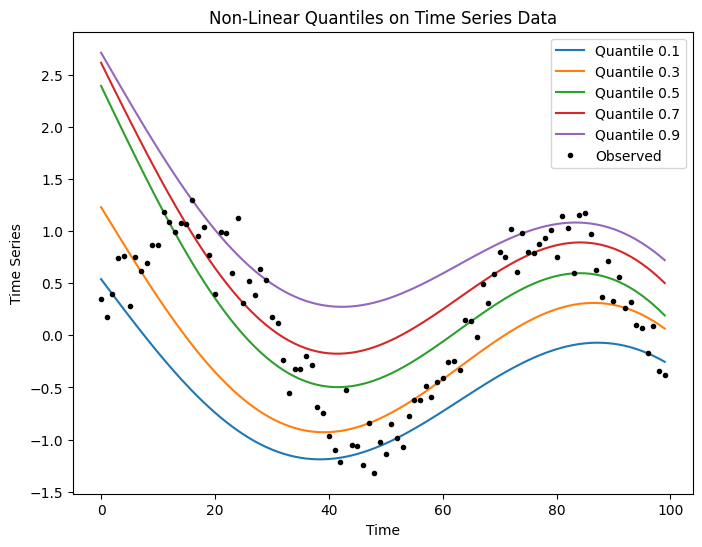

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(0)

# Generate time series data
n = 100  # Number of observations
time = np.arange(n)  # Time index
y = np.sin(0.1 * time) + np.random.normal(0, 0.2, size=n)  # Time series with sinusoidal pattern and noise

# Transform time series data
X = np.column_stack((time, np.sin(0.05 * time)))  # Non-linear transformations of time series data

# Perform quantile regression
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]  # Quantile levels
X = sm.add_constant(X)  # Add constant column
quantile_curves = []
for q in quantiles:
    model = sm.QuantReg(y, X).fit(q=q)
    quantile_curves.append(model.predict(X))

# Plot quantile curves
plt.figure(figsize=(8, 6))
for i, q in enumerate(quantiles):
    plt.plot(time, quantile_curves[i], label=f"Quantile {q}")
plt.plot(time, y, 'k.', label="Observed")
plt.xlabel("Time")
plt.ylabel("Time Series")
plt.title("Non-Linear Quantiles on Time Series Data")
plt.legend()
plt.show()


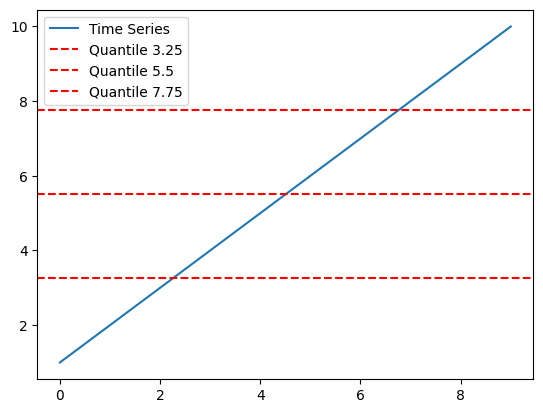

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example time series data
time_series = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Define the quantile values you want to calculate
quantiles = [0.25, 0.5, 0.75]

# Calculate the quantiles using numpy
time_series_array = np.array(time_series)
result = np.percentile(time_series_array, [q * 100 for q in quantiles])

# Plot the quantiles
plt.plot(time_series, label="Time Series")
for q in result:
    plt.axhline(q, color='r', linestyle='--', label=f"Quantile {q}")
plt.legend()

# Display the plot
plt.show()


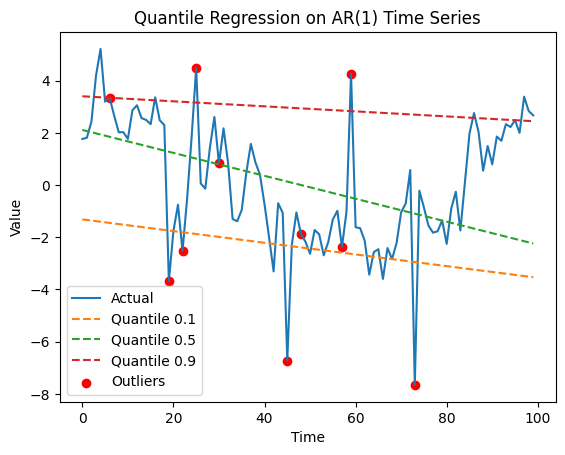

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Generate AR(1) time series data
np.random.seed(0)
n = 100  # Number of observations
beta = 0.8  # AR coefficient
error = np.random.normal(0, 1, n)  # Error term
data = np.zeros(n)
data[0] = error[0]
for i in range(1, n):
    data[i] = beta * data[i-1] + error[i]

# Add outliers to the data
outliers = np.random.choice(range(n), size=10, replace=False)
data[outliers] += np.random.normal(0, 3, 10)

# Prepare data for quantile regression
X = sm.add_constant(np.arange(n))
y = data

# Define quantile levels
quantiles = [0.1, 0.5, 0.9]

# Perform quantile regression for each quantile level
y_pred = np.zeros((len(quantiles), n))
for i, tau in enumerate(quantiles):
    model = sm.QuantReg(y, X)
    result = model.fit(q=tau)
    y_pred[i] = result.predict(X)

# Plot the results
plt.plot(np.arange(n), y, label='Actual')

for i, tau in enumerate(quantiles):
    plt.plot(np.arange(n), y_pred[i], label=f'Quantile {tau}', linestyle='--')

plt.scatter(outliers, data[outliers], color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Quantile Regression on AR(1) Time Series')
plt.legend()
plt.show()
